<a href="https://colab.research.google.com/github/yucan1028/thesis_code/blob/main/scenario_adpower_and_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
import calendar as cal
from datetime import timedelta
from scipy.optimize import minimize

##短縮バージョン

##エージェント作成

##キャリブレーション

In [ ]:
# 新潟県の観光客数予測係数
coefficients = {
    1: (103.04, -202751.93),
    2: (-1.39, 7507.21),
    3: (324.50, -648962.86),
    4: (289.50, -577025.86),
    5: (122.25, -239674.93),
    6: (47.54, -90435.79),
    7: (3.36, 116.00),
    8: (43.54, -75081.79),
    9: (11.75, -17978.07),
    10: (66.96, -128122.64),
    11: (42.07, -79626.86),
    12: (52.64, -102553.14)
}

# 佐渡島の観光客数の平均比率
average_ratios = {
    1: 0.00526,
    2: 0.00341,
    3: 0.00773,
    4: 0.01297,
    5: 0.02704,
    6: 0.03784,
    7: 0.02975,
    8: 0.02776,
    9: 0.03061,
    10: 0.02391,
    11: 0.01547,
    12: 0.00663
}

# 実際の観光客数のデータ
actual_tourist_counts = {
    (2011, 1): 29, (2012, 1): 28, (2013, 1): 24, (2014, 1): 27, (2015, 1): 24, (2016, 1): 23, (2017, 1): 21, (2018, 1): 24,
    (2011, 2): 20, (2012, 2): 19, (2013, 2): 16, (2014, 2): 17, (2015, 2): 14, (2016, 2): 16, (2017, 2): 11, (2018, 2): 14,
    (2011, 3): 29, (2012, 3): 35, (2013, 3): 38, (2014, 3): 36, (2015, 3): 36, (2016, 3): 41, (2017, 3): 38, (2018, 3): 28,
    (2011, 4): 54, (2012, 4): 96, (2013, 4): 100, (2014, 4): 86, (2015, 4): 75, (2016, 4): 66, (2017, 4): 63, (2018, 4): 82,
    (2011, 5): 141, (2012, 5): 189, (2013, 5): 191, (2014, 5): 176, (2015, 5): 172, (2016, 5): 180, (2017, 5): 184, (2018, 5): 163,
    (2011, 6): 191, (2012, 6): 227, (2013, 6): 236, (2014, 6): 224, (2015, 6): 199, (2016, 6): 195, (2017, 6): 174, (2018, 6): 172,
    (2011, 7): 239, (2012, 7): 253, (2013, 7): 225, (2014, 7): 201, (2015, 7): 203, (2016, 7): 193, (2017, 7): 168, (2018, 7): 166,
    (2011, 8): 392, (2012, 8): 416, (2013, 8): 381, (2014, 8): 321, (2015, 8): 327, (2016, 8): 328, (2017, 8): 310, (2018, 8): 320,
    (2011, 9): 187, (2012, 9): 222, (2013, 9): 182, (2014, 9): 182, (2015, 9): 172, (2016, 9): 172, (2017, 9): 143, (2018, 9): 134,
    (2011, 10): 194, (2012, 10): 213, (2013, 10): 173, (2014, 10): 160, (2015, 10): 148, (2016, 10): 158, (2017, 10): 127, (2018, 10): 117,
    (2011, 11): 101, (2012, 11): 110, (2013, 11): 85, (2014, 11): 78, (2015, 11): 80, (2016, 11): 66, (2017, 11): 55, (2018, 11): 58,
    (2011, 12): 26, (2012, 12): 25, (2013, 12): 24, (2014, 12): 22, (2015, 12): 19, (2016, 12): 26, (2017, 12): 26, (2018, 12): 16,
}

# 年ごとの平均レビュースコアを格納する辞書
annual_review_averages = {
    2011: 2.9258606425670117,
    2012: 3.0164292657943963,
    2013: 3.110876348585283,
    2014: 3.2203552079844324,
    2015: 3.1497245451183953,
    2016: 3.1512590863985337,
    2017: 2.932871734209716,
    2018: 2.966819683388602
}


##デルタとラムダの最適化

In [ ]:
def predict_tourist_counts(year, month, delta, lambda_, review_averages):
    # 新潟県の観光客数を計算
    niigata_tourists = coefficients[month][0] * year + coefficients[month][1]

    # 佐渡島の潜在的な観光客数を計算
    sado_potential = niigata_tourists * delta

    # 佐渡島へ行く観光客数を計算
    previous_year = year - 1 if year > 2011 else 2011
    review_adjustment = (review_averages.get(previous_year, 2.5) - 2.5) * lambda_
    sado_tourists = sado_potential * (1 + review_adjustment)

    return int(round(sado_tourists))

def calibrate_parameters(years):
    best_params = {}

    for year in years:
        min_error = float('inf')
        best_delta = 0
        best_lambda = 0

        for delta in np.linspace(0, 0.1, 20):  # Δの範囲を調整
            for lambda_value in np.linspace(0, 0.1, 20):  # λの範囲を調整
                total_error = 0
                for month in range(1, 13):
                    predicted = predict_tourist_counts(year, month, delta, lambda_value, annual_review_averages)
                    actual = actual_tourist_counts.get((year, month), 0)
                    total_error += abs(predicted - actual)

                if total_error < min_error:
                    min_error = total_error
                    best_delta = delta
                    best_lambda = lambda_value

        best_params[year] = (best_delta, best_lambda)

    return best_params

# キャリブレーションの実行
calibrated_params = calibrate_parameters(range(2011, 2019))
for year, params in calibrated_params.items():
    print(f"Year {year}: Δ = {params[0]}, λ = {params[1]}")


Year 2011: Δ = 0.02631578947368421, λ = 0.06315789473684211
Year 2012: Δ = 0.031578947368421054, λ = 0.02631578947368421
Year 2013: Δ = 0.02631578947368421, λ = 0.09473684210526316
Year 2014: Δ = 0.02631578947368421, λ = 0.0
Year 2015: Δ = 0.021052631578947368, λ = 0.08947368421052632
Year 2016: Δ = 0.021052631578947368, λ = 0.09473684210526316
Year 2017: Δ = 0.021052631578947368, λ = 0.005263157894736842
Year 2018: Δ = 0.015789473684210527, λ = 0.1


In [ ]:
calibrated_params

{2011: (0.02631578947368421, 0.06315789473684211),
 2012: (0.031578947368421054, 0.02631578947368421),
 2013: (0.02631578947368421, 0.09473684210526316),
 2014: (0.02631578947368421, 0.0),
 2015: (0.021052631578947368, 0.08947368421052632),
 2016: (0.021052631578947368, 0.09473684210526316),
 2017: (0.021052631578947368, 0.005263157894736842),
 2018: (0.015789473684210527, 0.1)}

##平均割合の最適化

##月ごとに平均割合（季節性）を最適化

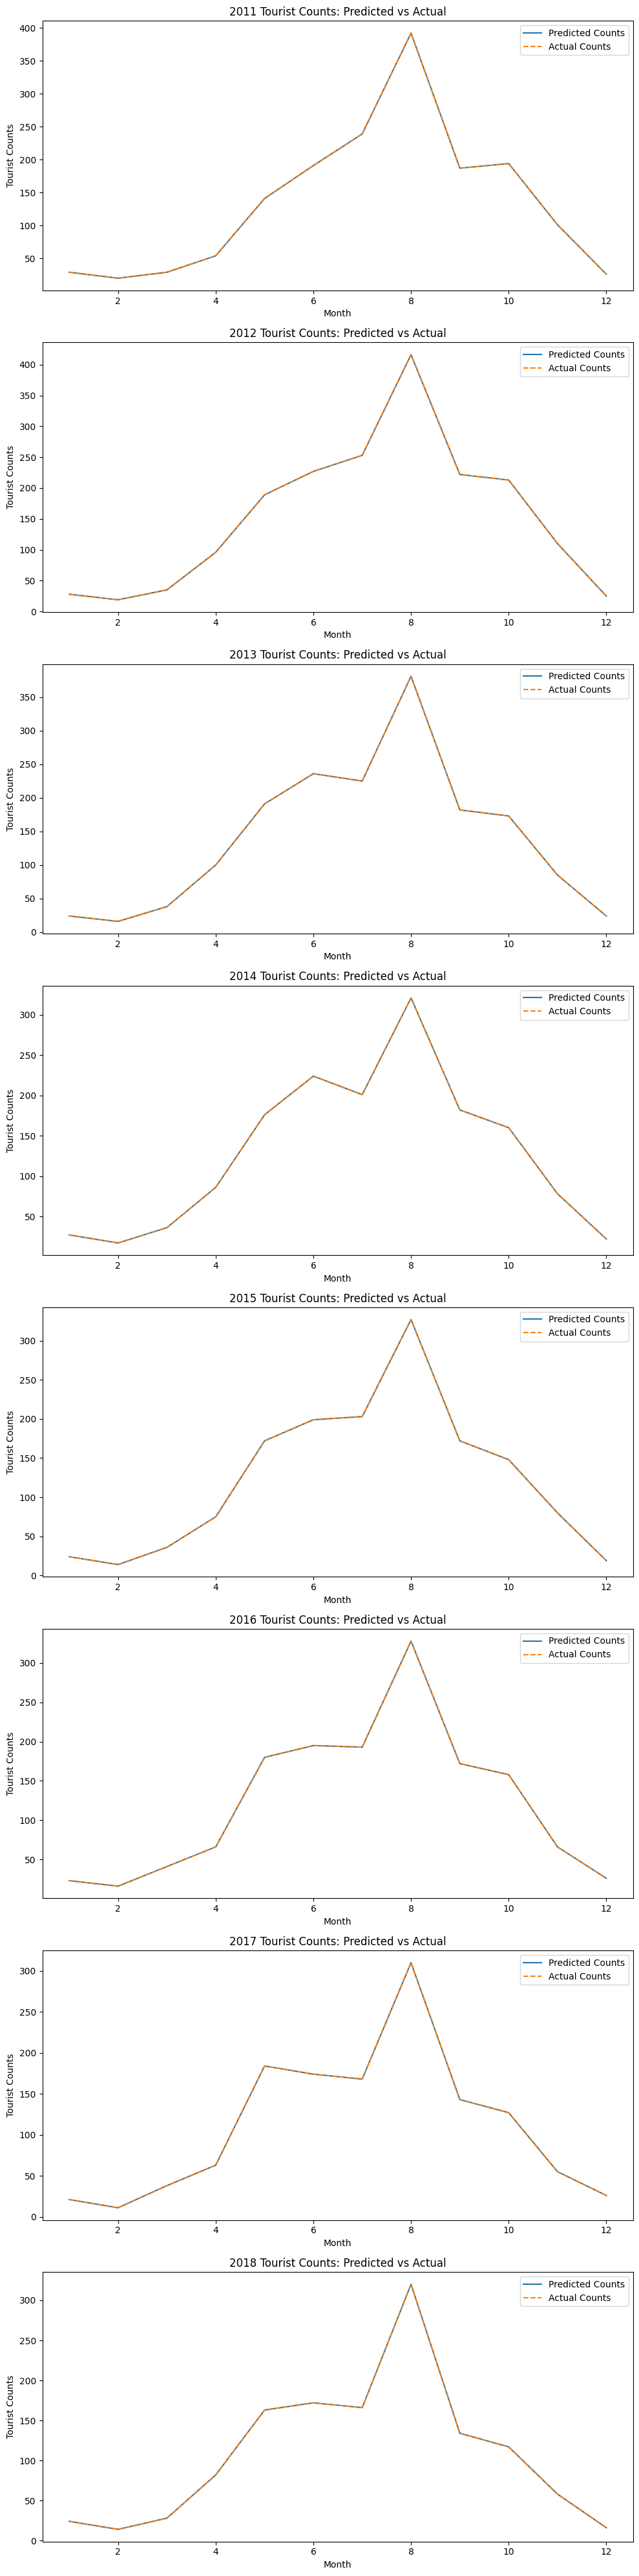

In [ ]:
# 年ごとに最適化された月別平均割合を計算する関数
def optimize_monthly_ratios_for_year(year):
    delta, lambda_ = calibrated_params[year]
    optimized_ratios = []

    for month in range(1, 13):
        def calculate_error(monthly_ratio):
            niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
            sado_potential = niigata_tourists * (monthly_ratio + delta)
            review_adjustment = (annual_review_averages.get(year-1, 2.5) - 2.5) * lambda_
            predicted = sado_potential * (1 + review_adjustment)
            actual = actual_tourist_counts.get((year, month), 0)
            return abs(predicted - actual)

        result = minimize(calculate_error, 0.05)
        optimized_ratios.append(result.x[0])

    return optimized_ratios

# 各年の最適化された月別平均割合を計算し、グラフをプロット
fig, axs = plt.subplots(8, 1, figsize=(10, 40))

for i, year in enumerate(range(2011, 2019)):
    optimized_ratios = optimize_monthly_ratios_for_year(year)
    predicted_counts = []
    actual_counts = [actual_tourist_counts.get((year, m), 0) for m in range(1, 13)]

    for month, ratio in zip(range(1, 13), optimized_ratios):
        niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
        sado_potential = niigata_tourists * (ratio + calibrated_params[year][0])
        review_adjustment = (annual_review_averages.get(year-1, 2.5) - 2.5) * calibrated_params[year][1]
        predicted = int(round(sado_potential * (1 + review_adjustment)))
        predicted_counts.append(predicted)

    axs[i].plot(range(1, 13), predicted_counts, label='Predicted Counts')
    axs[i].plot(range(1, 13), actual_counts, label='Actual Counts', linestyle='--')
    axs[i].set_title(f'{year} Tourist Counts: Predicted vs Actual')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Tourist Counts')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
# 各年の最適化された月別平均割合を計算し、データフレームに格納
data = []
for year in range(2011, 2019):
    optimized_ratios = optimize_monthly_ratios_for_year(year)
    for month, ratio in enumerate(optimized_ratios, start=1):
        data.append({
            'Year': year,
            'Month': month,
            'Optimized Ratio': ratio
        })

# データフレームの作成
optimized_ratios_df = pd.DataFrame(data)

# データフレームの表示
optimized_ratios_df


,Year,Month,Optimized Ratio
0,2011,1,-0.019816
1,2011,2,-0.022071
2,2011,3,-0.018275
3,2011,4,-0.015848
4,2011,5,-0.003463
...,...,...,...
91,2018,8,0.008207
92,2018,9,0.006613
93,2018,10,0.000225
94,2018,11,-0.005241


In [ ]:
import numpy as np

# Function to calculate standard deviation for a uniform distribution
def calculate_std_for_uniform_distribution(range_min, range_max):
    return (range_max - range_min) / np.sqrt(12)

# Given data for each capacity
range_min_5, range_max_5 = 0, 118
range_min_2, range_max_2 = 0, 166
range_min_1_3, range_max_1_3 = 0, 356

# Calculate standard deviation for each capacity
std_dev_5 = calculate_std_for_uniform_distribution(range_min_5, range_max_5)
std_dev_2 = calculate_std_for_uniform_distribution(range_min_2, range_max_2)
std_dev_1_3 = calculate_std_for_uniform_distribution(range_min_1_3, range_max_1_3)

# Print the standard deviations
print(f"Standard Deviation for Capacity 5: {std_dev_5}")
print(f"Standard Deviation for Capacity 2: {std_dev_2}")
print(f"Standard Deviation for Capacity 1.3: {std_dev_1_3}")


Standard Deviation for Capacity 5: 34.06366588218792
Standard Deviation for Capacity 2: 47.92007234273894
Standard Deviation for Capacity 1.3: 102.7683479157534


In [ ]:
# 各年の最適化された月別平均割合を計算
all_years_optimized_ratios = {}
for year in range(2011, 2019):
    all_years_optimized_ratios[year] = optimize_monthly_ratios_for_year(year)

# 各月の全年平均の月別平均割合を算出
monthly_average_ratios = []
for month in range(1, 13):
    monthly_total = 0
    for year in range(2011, 2019):
        monthly_total += all_years_optimized_ratios[year][month - 1]
    monthly_average = monthly_total / 8  # 8年間の平均
    monthly_average_ratios.append(monthly_average)

# 結果の表示
print("Monthly Average Ratios:", monthly_average_ratios)


Monthly Average Ratios: [-0.018600934431488653, -0.020400950472770286, -0.016323648235111166, -0.011260749892049329, 0.002058858373059372, 0.013267959256420304, 0.00543867242792035, 0.0032551617152760254, 0.006126235856362853, -0.0003756676326162969, -0.00857067024833134, -0.017240298021591844]


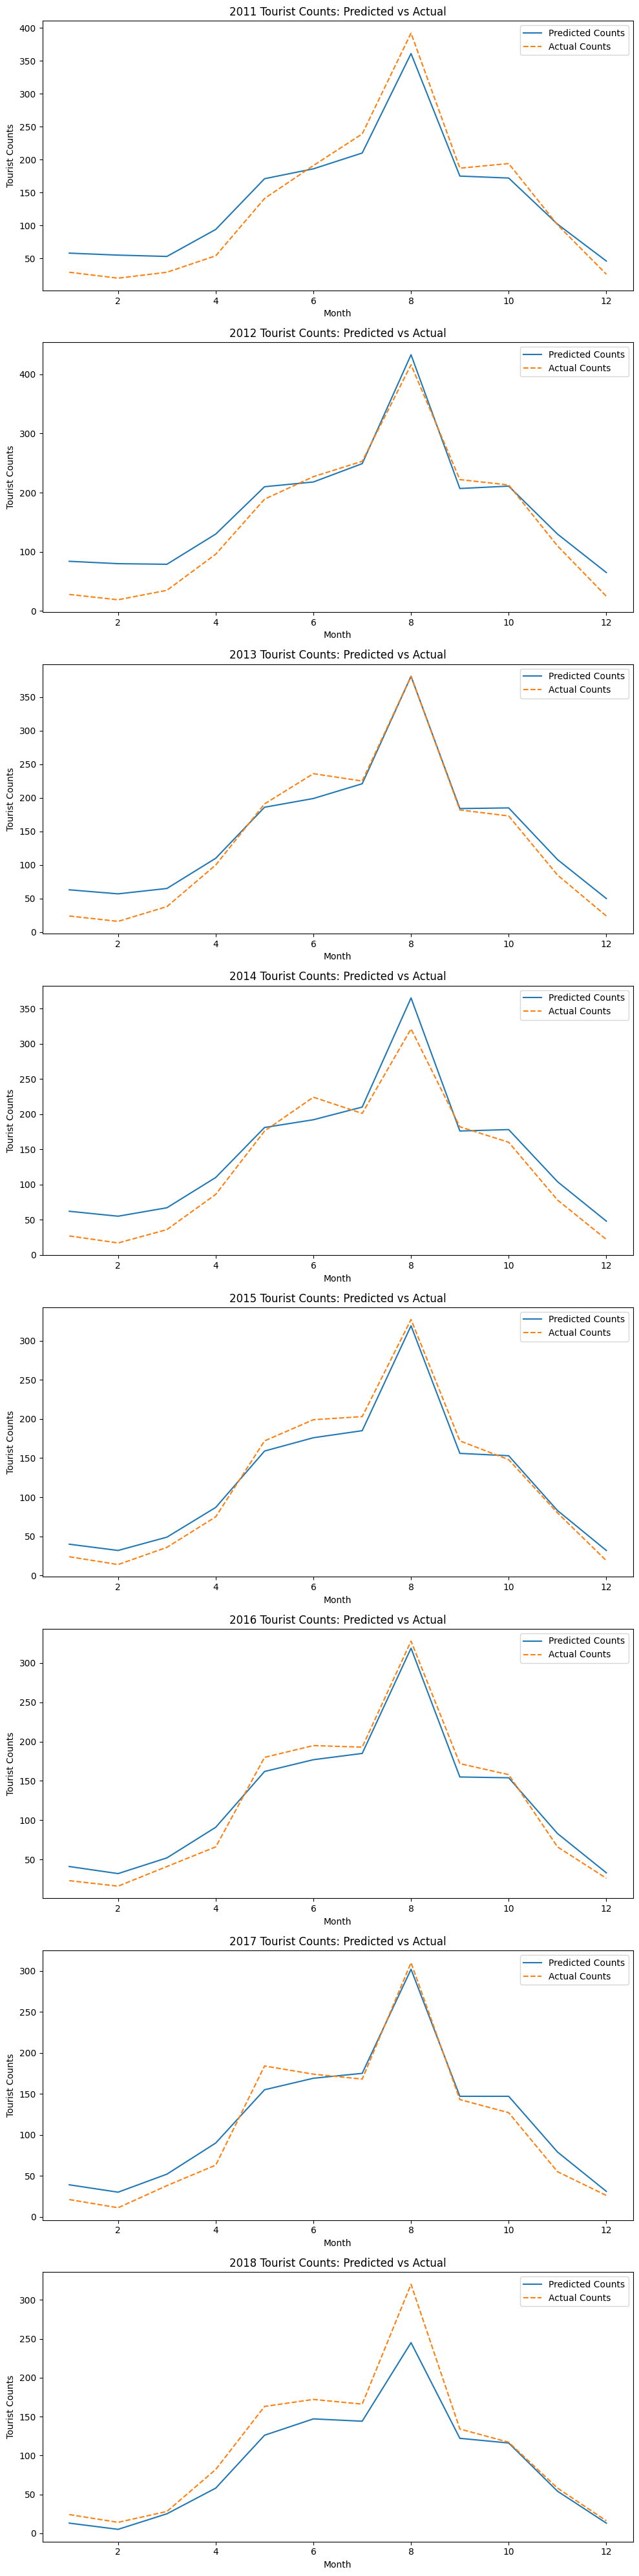

In [ ]:
# 月別平均割合
monthly_average_ratios = [-0.013378606954303655, -0.01468921242301886, -0.011726550812103453,
                          -0.008050605274971782, 0.001394634020823737, 0.009775035487700808,
                          0.00425331514222259, 0.0026015092432105356, 0.004595362944347498,
                          7.518520156755508e-05, -0.005902048809618914, -0.012402855629269537]

# 年別に予測値と実際の値をプロット
fig, axs = plt.subplots(8, 1, figsize=(10, 40))

for i, year in enumerate(range(2011, 2019)):
    delta, lambda_ = calibrated_params[year]
    predicted_counts = []
    actual_counts = [actual_tourist_counts.get((year, m), 0) for m in range(1, 13)]

    for month in range(1, 13):
        niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
        sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + delta)
        review_adjustment = (annual_review_averages.get(year - 1, 2.5) - 2.5) * lambda_
        predicted = int(round(sado_potential * (1 + review_adjustment)))
        predicted_counts.append(predicted)

    axs[i].plot(range(1, 13), predicted_counts, label='Predicted Counts')
    axs[i].plot(range(1, 13), actual_counts, label='Actual Counts', linestyle='--')
    axs[i].set_title(f'{year} Tourist Counts: Predicted vs Actual')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Tourist Counts')
    axs[i].legend()

plt.tight_layout()
plt.show()


##平均λ、Δバージョン


In [ ]:
# 平均Δと平均λを使用して年ごとの予測値をプロットする関数
def plot_predicted_vs_actual_with_averages():
    fig, axs = plt.subplots(8, 1, figsize=(10, 40))

    for i, year in enumerate(range(2011, 2019)):
        predicted_counts = []
        actual_counts = [actual_tourist_counts.get((year, m), 0) for m in range(1, 13)]

        for month in range(1, 13):
            niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
            sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + average_delta)
            review_adjustment = (annual_review_averages.get(year - 1, 2.5) - 2.5) * average_lambda
            predicted = int(round(sado_potential * (1 + review_adjustment)))
            predicted_counts.append(predicted)

        axs[i].plot(range(1, 13), predicted_counts, label='Predicted Counts')
        axs[i].plot(range(1, 13), actual_counts, label='Actual Counts', linestyle='--')
        axs[i].set_title(f'{year} Tourist Counts: Predicted vs Actual')
        axs[i].set_xlabel('Month')
        axs[i].set_ylabel('Tourist Counts')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# 月別平均割合
monthly_average_ratios = [-0.013378606954303655, -0.01468921242301886, -0.011726550812103453,
                          -0.008050605274971782, 0.001394634020823737, 0.009775035487700808,
                          0.00425331514222259, 0.0026015092432105356, 0.004595362944347498,
                          7.518520156755508e-05, -0.005902048809618914, -0.012402855629269537]

# 平均Δと平均λの計算
total_delta = sum(params[0] for params in calibrated_params.values())
total_lambda = sum(params[1] for params in calibrated_params.values())
average_delta = total_delta / len(calibrated_params)
average_lambda = total_lambda / len(calibrated_params)

# 予測と実際のデータをプロットする関数を修正して再実行
plot_predicted_vs_actual_with_averages()



In [ ]:
average_delta

In [ ]:
average_lambda

##ヒートマップ

<ipython-input-12-a56edfdfbf0d>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


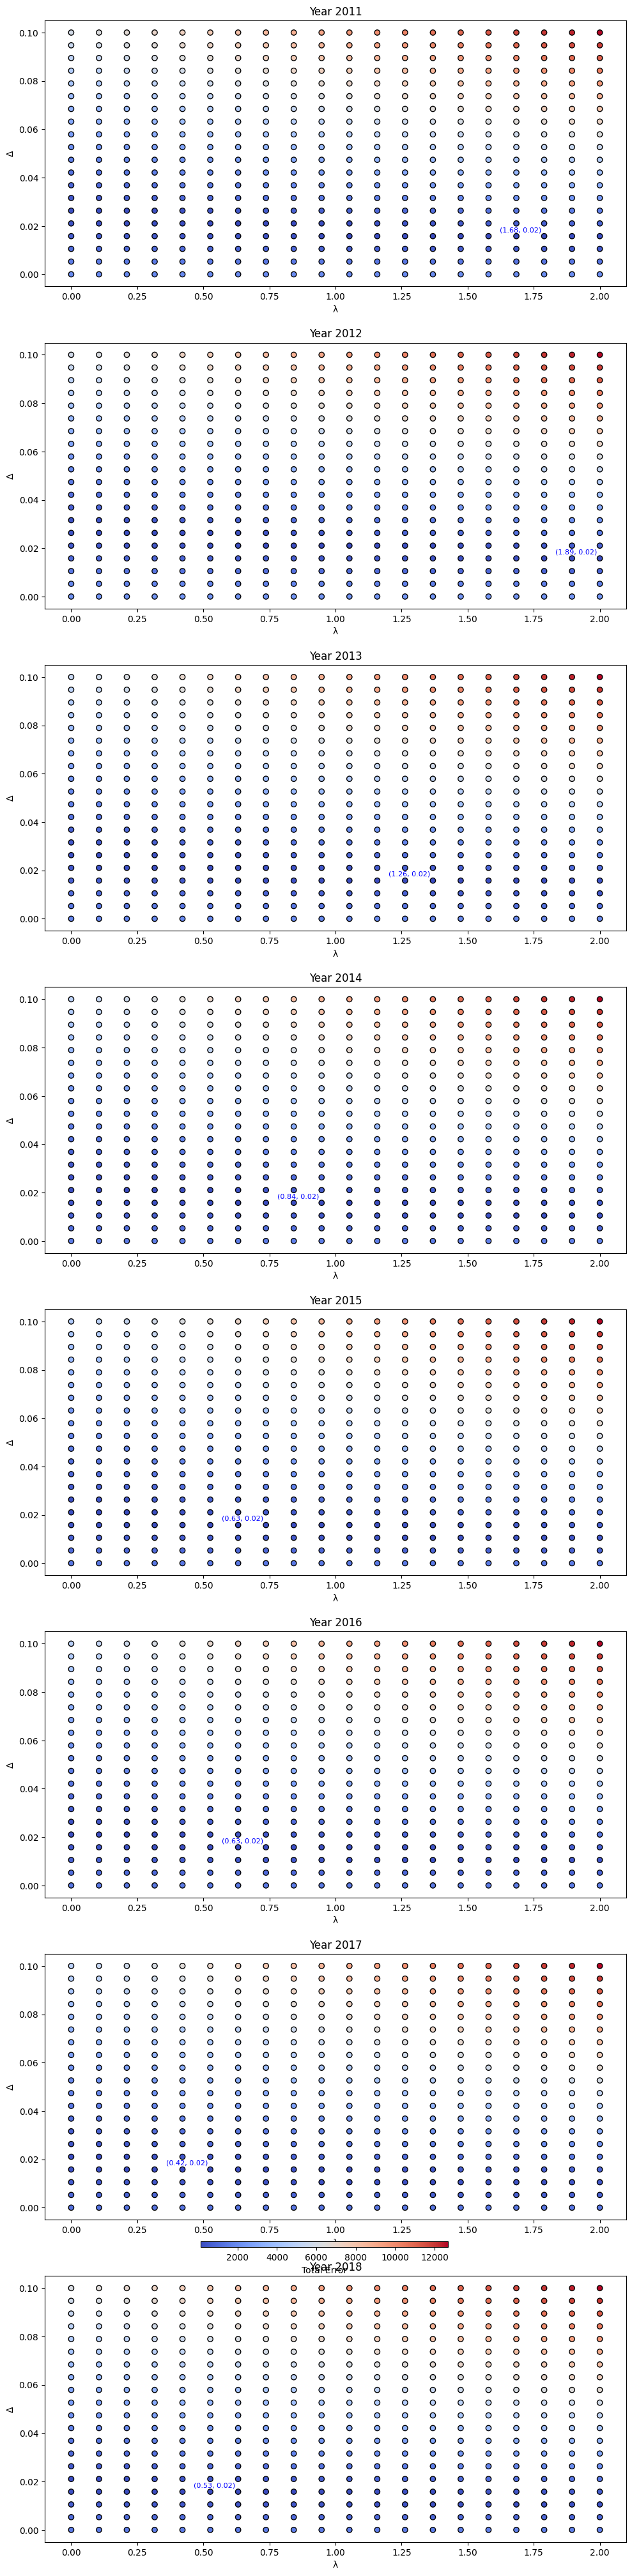

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

def predict_tourist_counts_with_ratio(year, month, delta, lambda_, monthly_ratio, review_averages, coefficients):
    # 新潟県の観光客数を計算
    niigata_tourists = coefficients[month][0] * year + coefficients[month][1]

    # 佐渡島の潜在的な観光客数を計算
    sado_potential = niigata_tourists * (monthly_ratio + delta)

    # 佐渡島へ行く観光客数を計算
    previous_year = year - 1 if year > 2011 else 2011
    review_adjustment = (review_averages.get(previous_year, 2.5) - 2.5) * lambda_
    sado_tourists = sado_potential * (1 + review_adjustment)

    return int(round(sado_tourists))

def calculate_errors_for_heatmap(year, delta, lambda_, monthly_average_ratios, review_averages, coefficients):
    total_error = 0
    for month in range(1, 13):
        predicted = predict_tourist_counts_with_ratio(year, month, delta, lambda_, monthly_average_ratios[month - 1], review_averages, coefficients)
        actual = actual_tourist_counts.get((year, month), 0)
        total_error += abs(predicted - actual)
    return total_error

# Δとλの範囲を設定（0以上に調整）
delta_range = np.linspace(0, 0.1, 20)
lambda_range = np.linspace(0, 2, 20)

# 年別に散布図を生成
fig, axs = plt.subplots(8, 1, figsize=(10, 40))

for i, year in enumerate(range(2011, 2019)):
    errors = []
    for delta in delta_range:
        for lambda_value in lambda_range:
            error = calculate_errors_for_heatmap(year, delta, lambda_value, monthly_average_ratios, annual_review_averages, coefficients)
            errors.append((delta, lambda_value, error))

    deltas, lambdas, total_errors = zip(*errors)
    scatter = axs[i].scatter(lambdas, deltas, c=total_errors, cmap='coolwarm', marker='o', edgecolor='k')

    # 最小誤差の座標を見つけ、表示
    min_error_idx = np.argmin(total_errors)
    min_delta, min_lambda, _ = errors[min_error_idx]
    axs[i].annotate(f'({min_lambda:.2f}, {min_delta:.2f})', (min_lambda, min_delta), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8, color='blue')

    axs[i].set_title(f'Year {year}')
    axs[i].set_xlabel('λ')
    axs[i].set_ylabel('Δ')

# カラーバーを追加
cbar = fig.colorbar(scatter, ax=axs, orientation='horizontal', pad=0.1, fraction=0.015, aspect=40, shrink=0.5)
cbar.set_label('Total Error')
plt.tight_layout()
plt.show()


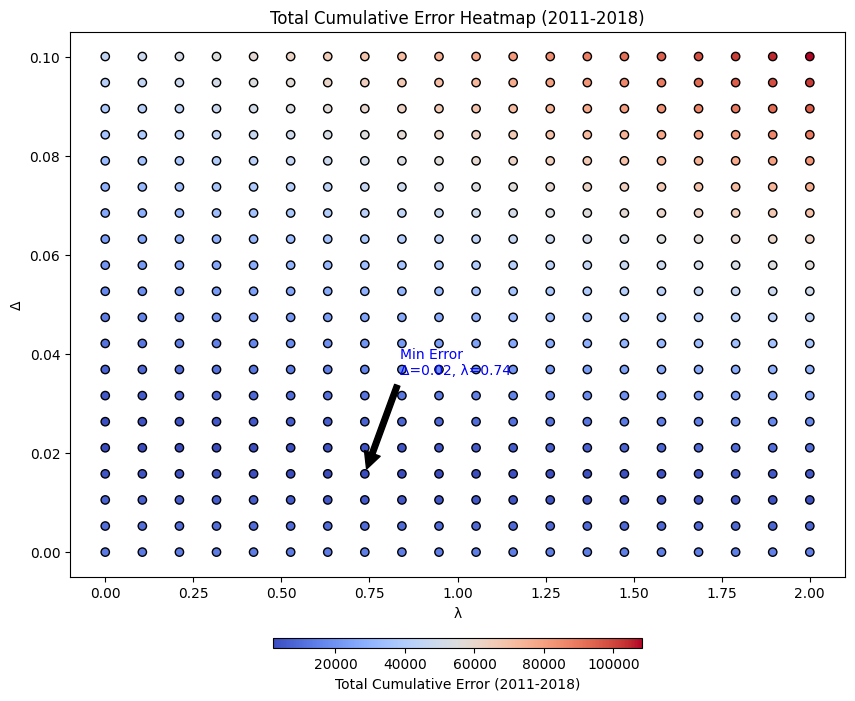

In [ ]:
# Δとλの範囲を設定
delta_range = np.linspace(0, 0.1, 20)
lambda_range = np.linspace(0, 2, 20)

# 各年の累積誤差を計算する関数
def calculate_total_errors_for_all_years(delta, lambda_):
    total_error_all_years = 0
    for year in range(2011, 2019):
        total_error_all_years += calculate_errors_for_heatmap(year, delta, lambda_, monthly_average_ratios, annual_review_averages, coefficients)
    return total_error_all_years

# ヒートマップ用のデータを生成
errors = []
for delta in delta_range:
    for lambda_value in lambda_range:
        error = calculate_total_errors_for_all_years(delta, lambda_value)
        errors.append((delta, lambda_value, error))

# Δ, λ, および累積誤差を抽出
deltas, lambdas, total_errors = zip(*errors)

# 最小誤差の点を見つける
min_error = min(total_errors)
min_error_idx = total_errors.index(min_error)
min_delta, min_lambda = deltas[min_error_idx], lambdas[min_error_idx]

# ヒートマップの作成
plt.figure(figsize=(10, 8))
scatter = plt.scatter(lambdas, deltas, c=total_errors, cmap='coolwarm', marker='o', edgecolor='k')

# 最小誤差の点に注釈を追加
plt.annotate(f'Min Error\nΔ={min_delta:.2f}, λ={min_lambda:.2f}',
             xy=(min_lambda, min_delta),
             xytext=(min_lambda + 0.1, min_delta + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='blue')

# カラーバーを追加
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, fraction=0.015, aspect=40, shrink=0.5)
cbar.set_label('Total Cumulative Error (2011-2018)')

# タイトルとラベルの設定
plt.title('Total Cumulative Error Heatmap (2011-2018)')
plt.xlabel('λ')
plt.ylabel('Δ')
plt.show()


##観光客生成

In [ ]:
review_averages = {
    2011: 2.9258606425670117,
    2012: 3.0164292657943963,
    2013: 3.110876348585283,
    2014: 3.2203552079844324,
    2015: 3.1497245451183953,
    2016: 3.1512590863985337,
    2017: 2.932871734209716,
    2018: 2.966819683388602
}

calibrated_params = {
    2011: (0.021052631578947368, 0.9473684210526315),
    2012: (0.021052631578947368, 1.263157894736842),
    2013: (0.02631578947368421, 0.21052631578947367),
    2014: (0.015789473684210527, 0.9473684210526315),
    2015: (0.015789473684210527, 0.8421052631578947),
    2016: (0.015789473684210527, 0.9473684210526315),
    2017: (0.010526315789473684, 1.263157894736842),
    2018: (0.010526315789473684, 1.3684210526315788)
}

# 月別平均比率
monthly_average_ratios = [-0.013378606954303655, -0.01468921242301886, -0.011726550812103453,
                          -0.008050605274971782, 0.001394634020823737, 0.009775035487700808,
                          0.00425331514222259, 0.0026015092432105356, 0.004595362944347498,
                          7.518520156755508e-05, -0.005902048809618914, -0.012402855629269537]


In [ ]:
import pandas as pd

# 佐渡島への実際の観光客数を計算する関数
def calculate_sado_tourists(year, month, delta, lambda_, review_averages):
    niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
    sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + delta)
    review_adjustment = (review_averages.get(year - 1, 2.5) - 2.5) * lambda_
    sado_tourists = int(round(sado_potential * (1 + review_adjustment)))
    return sado_tourists

# 予測された観光客数を計算する関数
def create_predicted_tourist_counts(years, average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda):
    predicted_counts = []

    for year in years:
        for month in range(1, 13):
            # 2012年から2018年まではcalibrated_paramsを使用し、2019年以降は平均値を使用
            if year <= 2018:
                delta, lambda_value = calibrated_params[year]
            else:
                delta, lambda_value = average_delta, average_lambda

            predicted = calculate_sado_tourists(year, month, delta, lambda_value, review_averages)
            predicted_counts.append([year, month, predicted])

    predicted_counts_df = pd.DataFrame(predicted_counts, columns=['Year', 'Month', 'Predicted_Tourists'])
    predicted_counts_df.set_index(['Year', 'Month'], inplace=True)
    return predicted_counts_df

# 平均Δと平均λの計算
total_delta = sum(params[0] for params in calibrated_params.values())
total_lambda = sum(params[1] for params in calibrated_params.values())
average_delta = total_delta / len(calibrated_params)
average_lambda = total_lambda / len(calibrated_params)

# 2012年から2026年までの予測された観光客数を計算
years = range(2012, 2027)
predicted_counts_df = create_predicted_tourist_counts(years, average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)

# 予測された観光客数を出力
print(predicted_counts_df)


            Predicted_Tourists
Year Month                    
2012 1                      54
     2                      46
     3                      56
     4                     109
     5                     217
...                        ...
2026 8                     259
     9                     126
     10                    130
     11                     63
     12                     19

[180 rows x 1 columns]


##データベース生成関数

In [ ]:
def generate_tourists(num_tourists, preference_std_dev, year, month):
    tourists = []
    start_date = pd.Timestamp(f'{year}-{month:02d}-01')
    end_date = pd.Timestamp(f'{year}-{month:02d}-{pd.Timestamp(start_date).days_in_month}')
    for i in range(num_tourists):
        budget = random.choices([1, 2, 3, 4], weights=[0.06, 0.36, 0.37, 0.21])[0]
        preference = [max(1, min(5, random.gauss(2.5, preference_std_dev))) for _ in range(4)]
        schedule_pref = random.choices([0, 1], weights=[0.6, 0.4])[0]
        stay_duration = random.choices([0, 1, 2, 3, 4], weights=[0.3, 0.3, 0.2, 0.1, 0.1])[0]

        random_days = random.randint(0, (end_date - start_date).days)
        initial_day = start_date + timedelta(days=random_days)

        tourists.append([
            i + 1, budget, *preference, schedule_pref, stay_duration,
            0, 0, 0, 0, initial_day, 0
        ])

    columns = [
        "ID", "Budget", "Pref1", "Pref2", "Pref3", "Pref4", "Schedule_pref",
        "Stay_duration", "Expectation", "Experience",
        "Satisfaction", "Review", "Initial_day", "select_plan"
    ]
    tourists = pd.DataFrame(tourists, columns=columns)

    return tourists



def generate_facilities():
    facilities = [
        ["大佐渡スカイライン", 0.2, 5, 2, 3, 3],
        ["白雲台", 0.2, 5, 2, 2, 3],
        ["大野亀", 0.2, 4, 2, 2, 3],
        ["二ツ亀", 0.2, 4, 2, 3, 2],
        ["平根崎", 0.2, 5, 2, 2, 2],
        ["尖閣湾揚島遊園", 0.2, 5, 2, 2, 3],
        ["玉堂窯", 0.2, 2, 4, 1, 4],
        ["佐渡金山", 0.2, 3, 5, 1, 5],
        ["北沢浮遊選鉱場", 0.2, 3, 5, 1, 3],
        ["きらりうむ佐渡", 0.2, 2, 4, 1, 3],
        ["めおと岩観光", 0.2, 4, 2, 2, 2],
        ["妙宣寺", 0.2, 2, 5, 1, 3],
        ["根本寺", 0.2, 2, 5, 1, 3],
        ["トキの森公園", 0.2, 4, 3, 2, 4],
        ["佐渡博物館", 0.2, 3, 5, 1, 4],
        ["両津郷土博物館", 0.2, 3, 4, 2, 3],
        ["真野御陵", 0.2, 2, 5, 1, 3],
        ["長浜荘", 0.2, 4, 2, 2, 2],
        ["佐渡歴史伝説館", 0.2, 1, 5, 1, 3],
        ["佐渡西三川ゴールドパーク", 0.2, 3, 4, 3, 3],
        ["尾畑酒造", 0.2, 1, 4, 1, 3],
        ["蓮華峰寺", 0.2, 3, 5, 1, 3],
        ["矢島・経島", 0.2, 4, 2, 4, 2],
        ["力屋観光汽船", 0.2, 4, 2, 5, 2],
        ["宿根木集落", 0.2, 3, 5, 2, 4],
        ["小木民俗博物館", 0.2, 1, 5, 1, 3],
        ["小木家（小木港）", 0.2, 2, 2, 1, 2],
        ["北雪酒造", 0.2, 1, 5, 1, 3]
    ]

    columns = ["Facility_name", "congestion", "Attr1", "Attr2", "Attr3", "Attr4"]
    facilities = pd.DataFrame(facilities, columns=columns)
    return facilities

def create_plan(plan_id, facilities, plan_name, is_specific_facility_plan=False):
    # Attr1, Attr2, Attr3, および Attr4 の値を取得
    attributes = facilities[['Attr1', 'Attr2', 'Attr3', 'Attr4']].values
    congestions = facilities['congestion'].values
    sights = facilities['Facility_name'].values.tolist()

    # 平均値を計算（Attr4を含む）
    attributes_avg = np.mean(attributes, axis=0)
    congestions_avg = np.mean(congestions)

    price = random.choices([1, 2, 3, 4], [0.1, 0.3, 0.4, 0.2])[0]
    selected_count = 0
    initial_rating = 3
    days = random.choice([0, 1, 2, 3, 4])
    deterioration = random.uniform(3, 5)

    # 佐渡金山を含むプランの広告力を0.5に設定、それ以外は0から0.2の間でランダム
    ad_power = 0.5 if is_specific_facility_plan else random.uniform(0, 0.2)

    return {
        "ID": plan_id,
        "Plan_name": plan_name,
        "Attr1": attributes_avg[0],
        "Attr2": attributes_avg[1],
        "Attr3": attributes_avg[2],
        "Attr4": attributes_avg[3],  # Attr4の平均値を追加
        "Price": price,
        "Initial_rating": initial_rating,
        "Ad_power": ad_power,
        "Selected_count": selected_count,
        "Congestion": congestions_avg,
        "Days": days,
        "Sights": ', '.join(sights),
        "Deterioration": deterioration
    }


def generate_plans(num_single, num_double, num_triple, facilities):
    plans = []
    plan_id = 1

    # 各施設を単体で含むプランを生成
    for _, fac in facilities.iterrows():
        plan = create_plan(plan_id, pd.DataFrame([fac]), f"Plan_{plan_id}")
        plans.append(plan)
        plan_id += 1

    # ランダムに2施設を含むプランを生成
    for _ in range(num_double):
        selected_facilities = facilities.sample(2)
        plan = create_plan(plan_id, selected_facilities, f"Plan_{plan_id}")
        plans.append(plan)
        plan_id += 1

    # ランダムに3施設を含むプランを生成
    for _ in range(num_triple):
        selected_facilities = facilities.sample(3)
        plan = create_plan(plan_id, selected_facilities, f"Plan_{plan_id}")
        plans.append(plan)
        plan_id += 1

    return pd.DataFrame(plans)


def generate_crowd(year, num_days):
    # 平日と土日の混雑度を定義する
    weekday_congestion = np.random.uniform(low=0.3, high=0.7, size=(num_days,))
    weekend_congestion = weekday_congestion * 1.5  # 土日は混雑度を1.5倍にする

    # 繁忙期の混雑度を定義する
    busy_months = [1, 3, 7, 8, 12]
    month_congestion = np.ones((num_days,))

    for i in busy_months:
        days_in_month = cal.monthrange(year, i)[1]
        start_day = sum(cal.monthrange(year, m)[1] for m in range(1, i))
        end_day = min(start_day + days_in_month, num_days)  # 配列のサイズを超えないように調整
        month_congestion[start_day:end_day] *= 1.4

    # 混雑度を計算
    congestion = []
    dates = []

    for month in range(1, 13):
        for day in range(1, cal.monthrange(year, month)[1] + 1):
            date = f"{year}-{month:02d}-{day:02d}"
            dates.append(date)
            day_of_week = cal.weekday(year, month, day)
            if day_of_week in [5, 6]:  # 土日
                congestion_value = weekend_congestion[len(congestion) % num_days] * (1.4 if month in busy_months else 1)
            else:  # 平日
                congestion_value = weekday_congestion[len(congestion) % num_days] * (1.4 if month in busy_months else 1)
            congestion.append(min(congestion_value, 1.0))  # 混雑度の最大値を1に制限

    crowd_df = pd.DataFrame({"Date": dates, "Congestion": congestion})
    return crowd_df.sample(frac=1).reset_index(drop=True)  # ランダムにシャッフルしてから返す

def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def adjust_ad_power(plans, ad_power_change):
    adjusted_plans = plans.copy()
    adjusted_plans['Ad_power'] = adjusted_plans['Ad_power'] + ad_power_change
    return adjusted_plans



In [ ]:
# 平均Δと平均λの計算
total_delta = sum(params[0] for params in calibrated_params.values())
total_lambda = sum(params[1] for params in calibrated_params.values())
average_delta = total_delta / len(calibrated_params)
average_lambda = total_lambda / len(calibrated_params)

In [ ]:
# 佐渡島への実際の観光客数を計算する関数
def calculate_sado_tourists(year, month, delta, lambda_, review_averages):
    niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
    sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + delta)
    review_adjustment = (review_averages.get(year - 1, 2.5) - 2.5) * lambda_
    sado_tourists = int(round(sado_potential * (1 + review_adjustment)))
    return sado_tourists

def create_yearly_predicted_counts(years, average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda):
    yearly_predicted_counts = {}
    for year in years:
        predicted_counts = []
        for month in range(1, 13):
            if year <= 2018:
                delta, lambda_value = calibrated_params[year]
            else:
                delta, lambda_value = average_delta, average_lambda

            predicted = calculate_sado_tourists(year, month, delta, lambda_value, review_averages)
            predicted_counts.append([month, predicted])

        df = pd.DataFrame(predicted_counts, columns=['Month', 'Predicted_Tourists'])
        df.set_index('Month', inplace=True)
        yearly_predicted_counts[year] = df

    return yearly_predicted_counts


##シミュレーション関数

In [ ]:
def select_plans(selected_tourists, plans):
   for index, tourist in selected_tourists.iterrows():
       # 観光客の選好ベクトルを作成（Pref4を追加）
       pref_vec = np.array([tourist['Pref1'], tourist['Pref2'], tourist['Pref3'], tourist['Pref4']])

       # plansのAttrベクトルを作成し、観光客の選好ベクトルとのコサイン類似度を計算（Attr4を含める）
       plans_vec = plans[['Attr1', 'Attr2', 'Attr3', 'Attr4']].values
       similarity = cosine_similarity(pref_vec.reshape(1, -1), plans_vec)

       # コサイン類似度が大きい順にplansを並べ替え
       plans['similarity'] = similarity.reshape(-1)
       sorted_plans = plans.sort_values(['similarity'], ascending=False)

       # 観光客のStay_durationとplansのDaysが一致するもののみを選択
       sorted_plans = sorted_plans[sorted_plans['Days'] == tourist['Stay_duration']]

       # 予算に近い順に並び替えのためのコピーを作成
       sorted_plans_copy = sorted_plans.copy()
       sorted_plans_copy.loc[:, 'budget_diff'] = abs(sorted_plans_copy['Price'] - tourist['Budget'])
       sorted_plans_copy = sorted_plans_copy.sort_values(['budget_diff'])

       # Initial_ratingが大きい順に並び替え
       sorted_plans_copy = sorted_plans_copy.sort_values(['Initial_rating'], ascending=False)

       # 0.05の確率でランダムに並び替え
       if np.random.random() < 0.2:
           sorted_plans_copy = sorted_plans_copy.sample(frac=1).reset_index(drop=True)

       # 最も上にあるプランを実行プランとして選択
       selected_plan = sorted_plans_copy.iloc[0]

       # plansのSelected_countに1を足す
       plans.loc[plans['ID'] == selected_plan['ID'], 'Selected_count'] += 1

       # selected_touristsのselect_planに選択されたプランのIDを入力
       selected_tourists.at[index, 'select_plan'] = selected_plan['ID']

   return selected_tourists


# 観光客に期待値が初期値として10点与えられる
INITIAL_EXPECTATION = 10

def calculate_expectation(selected_tourists, plans):
    for i, row in selected_tourists.iterrows():
        plan_id = row['select_plan']
        selected_plan = plans.loc[plans['ID'] == plan_id].iloc[0]

        # ゼロ除算や異常な値がないかチェック
        if selected_plan['Selected_count'] == 0 or np.isinf(selected_plan['Initial_rating']):
            print(f"Warning: Plan ID {plan_id} has an initial rating of {selected_plan['Initial_rating']} with {selected_plan['Selected_count']} selections.")
            continue

        # selected_planに書かれているIDのプランを取り出す
        selected_plan = plans[plans['ID'] == row['select_plan']].iloc[0]

        # 観光客の選好ベクトルを作成（Attr4とPref4を含む）
        pref_vector = np.array([row['Pref1'], row['Pref2'], row['Pref3'], row['Pref4']])

        # プランのAttrベクトルを作成（Attr4を含む）し、観光客の選好ベクトルとのコサイン類似度を計算
        attr_vector = selected_plan[['Attr1', 'Attr2', 'Attr3', 'Attr4']].to_numpy()
        similarity = cosine_similarity([pref_vector], [attr_vector])

        # 嗜好を計算し、データフレームに記入
        element1 = similarity[0][0] * 0.15
        selected_tourists.at[i, 'element1'] = element1

        # 金額を基にした要素の計算（0.6点満点）
        element2 = (selected_plan['Price'] / 4) * 0.6
        selected_tourists.at[i, 'element2'] = element2

        # 評価点数を基にした要素の計算（0.6点満点）
        element3 = (selected_plan['Initial_rating'] / 5) * 0.6
        selected_tourists.at[i, 'element3'] = element3

        # Ad_powerをデータフレームに記入
        ad_power = selected_plan['Ad_power']
        selected_tourists.at[i, 'Ad_power'] = ad_power

        # 期待値を計算
        expectation = (element1 + element2 + element3 + ad_power) * INITIAL_EXPECTATION
        selected_tourists.at[i, 'Expectation'] = expectation

    return selected_tourists


def calculate_experience(selected_plans, plans, Ship_congestion_df):
    for i, tourist in selected_plans.iterrows():
        # 選択されたプランの詳細を取得
        selected_plan = plans.loc[plans["ID"] == tourist["select_plan"]].iloc[0]

        # 'deterioration' 値をプランデータから取得
        deterioration = selected_plan["Deterioration"]

        # 'congestion' 値を計算
        congestion = selected_plan["Congestion"]
        if congestion <= 0.5:
            congestion_value = 5
        elif 0.5 < congestion < 0.8:
            congestion_value = 4
        elif 0.8 <= congestion <= 1.0:
            congestion_value = 3
        elif 1.0 < congestion < 1.2:
            congestion_value = 2
        elif 1.2 <= congestion < 1.4:
            congestion_value = 1
        else:
            congestion_value = 0

        # 観光客の 'Initial_day' と 'Ship_congestion_df' の 'Date' が一致するか確認し、'traffic' 値を計算
        ship_congestion_row = Ship_congestion_df[Ship_congestion_df["Date"] == tourist["Initial_day"].strftime("%Y-%m-%d")]
        if not ship_congestion_row.empty:
            ship_congestion = ship_congestion_row["Congestion"].iloc[0]
            if 0.4 <= ship_congestion < 0.7:
                ship_value = 5
            elif 0.7 <= ship_congestion < 0.9:
                ship_value = 3
            elif 0.9 <= ship_congestion < 1:
                ship_value = 1
            else:
                ship_value = 0
        else:
            ship_value = 0  # または適切なデフォルト値を設定

        # 'Overall satisfaction' をランダム値で計算
        overall_satisfaction = np.random.uniform(2, 5)
        if np.random.random() < 0.01:
            overall_satisfaction = 1

        # 'Experience' を計算し、データフレームに割り当て
        experience = congestion_value + deterioration + ship_value + overall_satisfaction
        selected_plans.at[i, 'congestion'] = congestion_value
        selected_plans.at[i, 'deterioration'] = deterioration
        selected_plans.at[i, 'traffic'] = ship_value
        selected_plans.at[i, 'Other'] = overall_satisfaction
        selected_plans.at[i, 'Experience'] = experience

    return selected_plans

def calculate_satisfaction(row, plans):
    experience = row['Experience']
    expectation = row['Expectation']
    select_plan = row['select_plan']

    # 選択したプランの選択回数を取得
    selected_count = plans.loc[plans['ID'] == select_plan, 'Selected_count'].iloc[0]

    # 選択回数に基づいた調整係数を適用
    adjustment = np.log(selected_count + 1)

    # 満足度の計算
    satisfaction = (experience - expectation) * adjustment
    return satisfaction

# 満足度をレビューに変換
def scale_to_review(satisfaction, min_satisfaction, max_satisfaction):
    if max_satisfaction == min_satisfaction:  # 分母が0になるのを防ぐ
        return 1 if satisfaction >= 0 else 5  # 体験が期待を上回れば最高点、下回れば最低点
    scaled_satisfaction = 1 + (satisfaction - min_satisfaction) / (max_satisfaction - min_satisfaction) * 4
    review = round(scaled_satisfaction, 1)  # 小数点第一位で四捨五入
    return review

def update_plan_ratings(selected_plans, plans):
    for index, row in selected_plans.iterrows():
        plan_id = row['select_plan']
        review = row['Review']

        current_rating = plans.loc[plans['ID'] == plan_id, 'Initial_rating'].iloc[0]
        selected_count = plans.loc[plans['ID'] == plan_id, 'Selected_count'].iloc[0]

        # 選択回数が少ない場合の調整
        if selected_count < 5:  # 例として5回を閾値とする
            weight = 0.5  # 重み付けを半分にする
        else:
            weight = 1  # 通常の重み付け

        new_total_rating = (current_rating * selected_count * weight) + review
        new_rating = new_total_rating / ((selected_count + 1) * weight)

        plans.loc[plans['ID'] == plan_id, 'Initial_rating'] = new_rating
        plans.loc[plans['ID'] == plan_id, 'Selected_count'] = selected_count + 1

    return plans



In [ ]:
def run_simulation(predicted_counts_df, facilities, plans, year=None):
    simulation_results = {}

    # predicted_counts_dfの各行をイテレートする
    for index, row in predicted_counts_df.iterrows():
        year, month = index  # indexからyearとmonthを取得
        num_tourists = row['Predicted_Tourists']
        crowd_df = generate_crowd(year, 365)

        tourists = generate_tourists(num_tourists, 1, year, month)

        selected_tourists = select_plans(tourists, plans)
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度を更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

        # Satisfaction列の計算と追加
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        plans = update_plan_ratings(selected_tourists, plans)

        simulation_results[(year, month)] = selected_tourists

    return simulation_results, plans


##1年間分出力

In [ ]:
def run_simulation(yearly_counts_dict, facilities, plans, specified_year):
    simulation_results = {}

    predicted_counts_df = yearly_counts_dict[specified_year]
    crowd_df = generate_crowd(specified_year, 365)

    for month, row in predicted_counts_df.iterrows():
        num_tourists = row['Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, specified_year, month)

        selected_tourists = select_plans(tourists, plans)
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度を更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

        # Satisfaction列の計算と追加
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        # プランのレビューと選択回数を更新
        plans = update_plan_ratings(selected_tourists, plans)

        simulation_results[(specified_year, month)] = selected_tourists

    return simulation_results, plans


In [ ]:
# 2024年の予測観光客数を生成
predicted_counts_2024 = create_predicted_tourist_counts([2024], average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)

# 新しいデータを既存のデータフレームに追加
predicted_counts_df = pd.concat([predicted_counts_df, predicted_counts_2024])


In [ ]:
# 平均Δと平均λの計算
total_delta = sum(params[0] for params in calibrated_params.values())
total_lambda = sum(params[1] for params in calibrated_params.values())
average_delta = total_delta / len(calibrated_params)
average_lambda = total_lambda / len(calibrated_params)

# 2012年から2019年までの予測された観光客数を計算
predicted_counts_2012_2019 = create_yearly_predicted_counts(range(2012, 2020), average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)

# 施設データベースの生成
facilities = generate_facilities()

# プランの生成
# 各施設を単体で含むプランを28個、ランダムに2施設を含むプランを41個、ランダムに3施設を含むプランを41個生成
plans = generate_plans(28, 41, 41, facilities)


In [ ]:
years = range(2023, 2027)
yearly_predicted_counts = create_yearly_predicted_counts(years, average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)

# Run the simulation for each year and store the results
all_simulation_results = {}
for year in years:  # Added colon here
    simulation_results, updated_plans = run_simulation(yearly_predicted_counts, facilities, plans, year)
    all_simulation_results[year] = simulation_results

In [ ]:
# 2024年から2026年までの結果を分析用にまとめる
analysis_results = {}
for year in range(2024, 2027):
    analysis_results[year] = all_simulation_results[year]

In [ ]:
# 空のシミュレーション結果ディクショナリを作成
simulation_results_2024 = {}

# 2024年の各月に対してシミュレーションを実行
for month in range(1, 13):
    monthly_predicted_counts = predicted_counts_2024[predicted_counts_2024.index.get_level_values('Month') == month]
    num_tourists = monthly_predicted_counts['Predicted_Tourists'].sum()
    crowd_df = generate_crowd(2024, 365)

    tourists = generate_tourists(num_tourists, 1, 2024, month)

    selected_tourists = select_plans(tourists, plans)
    selected_tourists = calculate_expectation(selected_tourists, plans)
    selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

    for index, row in selected_tourists.iterrows():
        satisfaction = calculate_satisfaction(row, plans)
        selected_tourists.at[index, 'Satisfaction'] = satisfaction

    max_satisfaction = selected_tourists['Satisfaction'].max()
    min_satisfaction = selected_tourists['Satisfaction'].min()
    selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

    plans = update_plan_ratings(selected_tourists, plans)

    simulation_results_2024[month] = selected_tourists

# 結果の確認
for month, results in simulation_results_2024.items():
    print(f"Month: {month}")
    print(results.head())  # 各月の結果の先頭の数行を表示

In [ ]:
# Selected_countが多い順にplansをソート
sorted_plans = plans.sort_values('Selected_count', ascending=False)

# ソートされたデータのグラフで可視化（IDを使用）
plt.figure(figsize=(30, 6))
plt.bar(sorted_plans['ID'].astype(str), sorted_plans['Selected_count'])
plt.xlabel('Plan ID')
plt.ylabel('Selected Count')
plt.title('Selected Count of Each Plan')
plt.xticks(rotation=45)
plt.show()


In [ ]:

# 選択回数の最小値と最大値を計算
min_selected_count = plans['Selected_count'].min()
max_selected_count = plans['Selected_count'].max()

# 結果を表示
print("最小選択回数:", min_selected_count)
print("最大選択回数:", max_selected_count)

In [ ]:

# 基本統計情報の計算
mean_selected_count = plans['Selected_count'].mean()
median_selected_count = plans['Selected_count'].median()
mode_selected_count = plans['Selected_count'].mode()[0]
std_selected_count = plans['Selected_count'].std()
quartiles = plans['Selected_count'].quantile([0.25, 0.5, 0.75]).to_dict()
min_id, max_id = plans.iloc[plans['Selected_count'].idxmin()]['ID'], plans.iloc[plans['Selected_count'].idxmax()]['ID']

# プランのランク付け
ranked_plans = plans.sort_values('Selected_count', ascending=False).reset_index(drop=True)

# 結果の表示
mean_selected_count, median_selected_count, mode_selected_count, std_selected_count, quartiles, min_id, max_id, ranked_plans

##グループ分け

In [ ]:
# 各グループのサイズを決定
group_size = len(sorted_plans) // 3

# グループ分け
popular_group = sorted_plans.iloc[:group_size]
middle_group = sorted_plans.iloc[group_size:2 * group_size]
unpopular_group = sorted_plans.iloc[2 * group_size:]

# 各グループの内訳を出力
print("Popular Group:")
print(popular_group)
print("\nMiddle Group:")
print(middle_group)
print("\nUnpopular Group:")
print(unpopular_group)


In [ ]:
def run_simulation_for_year(year, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda):
    simulation_results = {}

    for month in range(1, 13):
        # 予測された観光客数を計算
        if year <= 2018:
            delta, lambda_value = calibrated_params[year]
        else:
            delta, lambda_value = average_delta, average_lambda
        predicted_tourists = calculate_sado_tourists(year, month, delta, lambda_value, review_averages)

        # 混雑度データの生成
        crowd_df = generate_crowd(year, 365)

        # 観光客データを生成
        tourists = generate_tourists(predicted_tourists, preference_std_dev=1, year=year, month=month)
        selected_tourists = select_plans(tourists, plans)

        # 期待値、経験値、満足度の計算
        selected_tourists = calculate_expectation(selected_tourists, plans)
        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        # レビューの計算
        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        # プランの評価を更新
        plans = update_plan_ratings(selected_tourists, plans)
        simulation_results[month] = selected_tourists

    return simulation_results


In [ ]:
import pandas as pd

# 2024年のシミュレーション実行
simulation_results_2024 = run_simulation_for_year(2024, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

# 選択回数でプランをソートしてグループ分け
total_selected_counts_2024 = pd.Series(dtype=int)
for _, tourists in simulation_results_2024.items():
    total_selected_counts_2024 = total_selected_counts_2024.add(tourists['select_plan'].value_counts(), fill_value=0)

# プランデータフレームに選択回数を追加
plans['Selected_count'] = plans['ID'].map(total_selected_counts_2024).fillna(0).astype(int)

# プランを選択回数でソート
sorted_plans_2024 = plans.sort_values('Selected_count', ascending=False)

# 各グループの代表プランを決定
group_size = len(sorted_plans_2024) // 3
popular_plan_id = sorted_plans_2024.iloc[:group_size].tail(1)['ID'].values[0]  # 人気グループの代表プラン
middle_plan_id = sorted_plans_2024.iloc[group_size:2*group_size].tail(1)['ID'].values[0]  # 中間グループの代表プラン
unpopular_plan_id = sorted_plans_2024.iloc[2*group_size:].tail(1)['ID'].values[0]  # 不人気グループの代表プラン


##広告力

In [ ]:
# 固定シード値の設定
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

# 以前に生成したplansを使い回すためにコピー
original_plans = plans.copy()

# All 0.2 シナリオを最初に実行してグループ分けのための代表プランIDを取得
plans['Ad_power'] = 0.2  # 全てのプランの広告力を0.2に設定
simulation_results_all_02 = run_simulation_for_year(2024, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

# 選択回数を集計
total_selected_counts_all_02 = pd.Series(dtype=int)
for _, tourists in simulation_results_all_02.items():
    total_selected_counts_all_02 = total_selected_counts_all_02.add(tourists['select_plan'].value_counts(), fill_value=0)
plans['Selected_count'] = plans['ID'].map(total_selected_counts_all_02).fillna(0).astype(int)

# プランを選択回数でソートしてグループ分け
sorted_plans_all_02 = plans.sort_values('Selected_count', ascending=False)
group_size = len(sorted_plans_all_02) // 3
popular_plan_id = sorted_plans_all_02.iloc[:group_size].head(1)['ID'].values[0]
middle_plan_id = sorted_plans_all_02.iloc[group_size:2*group_size].head(1)['ID'].values[0]
unpopular_plan_id = sorted_plans_all_02.iloc[2*group_size:].head(1)['ID'].values[0]

# 広告力変更シナリオテスト
ad_power_scenarios = {
    "All 0.2": None,
    "Popular 0.5": popular_plan_id,
    "Middle 0.5": middle_plan_id,
    "Unpopular 0.5": unpopular_plan_id
}

# 各シナリオでシミュレーションを実行し、グラフに表示
for scenario, highlighted_plan_id in ad_power_scenarios.items():
    # plansをリセットし、シナリオに応じて広告力を設定
    plans = original_plans.copy()
    plans['Ad_power'] = 0.2  # 全プランの広告力を0.2に設定
    if highlighted_plan_id is not None:
        plans.loc[plans['ID'] == highlighted_plan_id, 'Ad_power'] = 0.5

    # シミュレーション実行
    simulation_results = run_simulation_for_year(2024, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

    # 選択回数の集計
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    plans['Selected_count'] = plans['ID'].map(total_selected_counts).fillna(0).astype(int)

    # グラフ描画
    plt.figure(figsize=(30, 6))
    for plan_id, count in zip(sorted_plans['ID'], sorted_plans['Selected_count']):
        bar_color = 'red' if plan_id in [popular_plan_id, middle_plan_id, unpopular_plan_id] else 'grey'
        plt.bar(str(plan_id), count, color=bar_color)

    plt.xlabel('Plan ID')
    plt.ylabel('Selected Count')
    plt.title(f'Selected Count for {scenario} Scenario\n'
              f'Popular Plan ID: {popular_plan_id}, Middle Plan ID: {middle_plan_id}, Unpopular Plan ID: {unpopular_plan_id}')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
import pandas as pd

# CSVファイルに保存するデータフレームを作成
ad_power_output_df = pd.DataFrame()

for scenario, highlighted_plan_id in ad_power_scenarios.items():
    # 2024年のシミュレーションを再実行
    simulation_results = run_simulation_for_year(2024, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

    # 結果の集計
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    plans['Selected_count'] = plans['ID'].map(total_selected_counts).fillna(0).astype(int)

    # 選択回数をデータフレームに追加
    scenario_df = pd.DataFrame(total_selected_counts, columns=['Total Selected Counts'])
    scenario_df['Scenario'] = scenario
    scenario_df['Highlighted Plan ID'] = highlighted_plan_id

    # データフレームを結合
    ad_power_output_df = pd.concat([ad_power_output_df, scenario_df])

# CSVファイルに保存
ad_power_output_df.to_csv('ad_power_scenario_results.csv', index_label='Plan ID')


差分の分析

In [ ]:
# 各シナリオでの選択回数を保存する辞書
selection_counts_by_scenario = {}

# 各シナリオのシミュレーションを実行して結果を収集
for scenario, ad_power in ad_power_scenarios.items():
    # 広告力の設定
    adjusted_plans = plans.copy()
    adjusted_plans['Ad_power'] = 0.2  # 一律の広告力を設定
    if isinstance(ad_power, tuple):
        plan_id, new_ad_power = ad_power
        adjusted_plans.loc[adjusted_plans['ID'] == plan_id, 'Ad_power'] = new_ad_power

    # シミュレーションの実行
    simulation_results = run_simulation_for_year(2024, facilities, adjusted_plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

    # 選択回数の集計
    selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        selected_counts = selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)

    # 結果を保存
    selection_counts_by_scenario[scenario] = selected_counts

# 基準シナリオと他のシナリオの差分を計算して可視化
baseline_counts = selection_counts_by_scenario["All 0.2"]
for scenario, counts in selection_counts_by_scenario.items():
    if scenario != "All 0.2":
        # 差分の計算
        difference = counts - baseline_counts

        # 差分の可視化
        plt.figure(figsize=(20, 6))
        difference.plot(kind='bar')
        plt.xlabel('Plan ID')
        plt.ylabel('Difference in Selected Count')
        plt.title(f'Difference in Selection Counts: {scenario} vs All 0.2 Scenario')
        plt.xticks(rotation=45)
        plt.show()


時系列分析

In [ ]:
# 各シナリオの結果を格納するためのデータフレームを初期化
scenario_results = pd.DataFrame()

for scenario, ad_power in ad_power_scenarios.items():
    # 各シナリオにおける広告力の調整とシミュレーション実行
    adjusted_plans = plans.copy()
    adjusted_plans['Ad_power'] = 0.2
    if isinstance(ad_power, tuple):
        plan_id, new_ad_power = ad_power
        adjusted_plans.loc[adjusted_plans['ID'] == plan_id, 'Ad_power'] = new_ad_power

    simulation_results = run_simulation_for_year(2024, facilities, adjusted_plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

    # 選択回数の集計
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    adjusted_plans['Selected_count'] = adjusted_plans['ID'].map(total_selected_counts).fillna(0).astype(int)

    # シナリオの結果をデータフレームに追加
    scenario_results[scenario] = adjusted_plans.set_index('ID')['Selected_count']

# 各シナリオの選択回数の差分を計算
differences = scenario_results.diff(axis=1).fillna(0)

# 差分の表示
print("選択回数の差分:")
print(differences)

##レビュー

In [ ]:
# Example of creating a dummy Ship_congestion_df
Ship_congestion_df = pd.DataFrame({
    'Date': pd.date_range(start='2024-01-01', periods=365, freq='D'),
    'Congestion_Level': np.random.uniform(0, 1, 365)  # Random congestion levels
})


In [ ]:
def scale_to_review(satisfaction, min_satisfaction, max_satisfaction, review_rate=1.0):
    if max_satisfaction == min_satisfaction:
        return 1 if satisfaction >= 0 else 5
    scaled_review = 1 + (satisfaction - min_satisfaction) / (max_satisfaction - min_satisfaction) * 4
    review = round(scaled_review * review_rate, 1)
    return review

def update_plan_ratings(selected_tourists, plans):
    for plan_id in plans['ID']:
        # 'select_plan' カラムを使用してプランIDに基づくレビューを抽出
        reviews = selected_tourists[selected_tourists['select_plan'] == plan_id]['Review']
        if not reviews.empty:
            current_rating = plans.loc[plans['ID'] == plan_id, 'Initial_rating'].iloc[0]
            new_total_rating = (current_rating * len(reviews)) + reviews.sum()
            new_rating = new_total_rating / (len(reviews) + 1)
            plans.loc[plans['ID'] == plan_id, 'Initial_rating'] = new_rating
    return plans

# ベースラインシナリオでの観光客データの生成と保存
def generate_and_save_tourists(predicted_counts_df, year):
    tourists_data = {}
    for index, row in predicted_counts_df.iterrows():
        month = index[1]
        num_tourists = row['Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, year, month)
        tourists_data[month] = tourists
    return tourists_data

def calculate_monthly_selections(simulation_results, plan_id):
    monthly_selections = {}
    for month in range(1, 13):
        key = (2024, month)
        if key in simulation_results:
            selected_count = simulation_results[key]['select_plan'].value_counts().get(plan_id, 0)
            monthly_selections[month] = selected_count
        else:
            monthly_selections[month] = 0
    return monthly_selections

def generate_and_save_tourists(predicted_counts_df, year):
    tourists_data = {}
    for month in range(1, 13):
        num_tourists = predicted_counts_df.loc[(year, month), 'Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, year, month)
        tourists_data[month] = tourists
    return tourists_data

# 2024年の観光客データを生成
tourists_data_2024 = generate_and_save_tourists(predicted_counts_2024, 2024)

def run_simulation_with_saved_tourists(facilities, plans, tourists_data, year, Ship_congestion_df):
    simulation_results = {}

    for month, tourists in tourists_data.items():
        # 観光客にプランを選択させる
        selected_tourists = select_plans(tourists, plans)

        # 観光客の期待値を計算
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度を更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        # 観光客の体験値を計算
        selected_tourists = calculate_experience(selected_tourists, plans, Ship_congestion_df)

        # 満足度とレビューの計算
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction
            max_satisfaction = selected_tourists['Satisfaction'].max()
            min_satisfaction = selected_tourists['Satisfaction'].min()
            selected_tourists.at[index, 'Review'] = scale_to_review(satisfaction, min_satisfaction, max_satisfaction)

        # プランの評価を更新
        plans = update_plan_ratings(selected_tourists, plans)

        # 結果を保存
        simulation_results[(year, month)] = selected_tourists

    return simulation_results, plans

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定シード値の設定
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

# 以前に生成したplansを使い回すためにコピー
original_plans = plans.copy()

# レビュー率変更シナリオテスト
review_rate_scenarios = {
    "Baseline 50%": [],
    "Popular 100%": popular_plan_id,
    "Middle 100%": middle_plan_id,
    "Unpopular 100%": unpopular_plan_id
}

for scenario, special_plan_id in review_rate_scenarios.items():
    # plansをリセット
    plans = original_plans.copy()

    # 特定のプランのレビュー確率を変更
    if special_plan_id:
        # 特定のプランのレビュー確率を100%に設定
        print(f"Scenario '{scenario}': Highlighted Plan ID - {special_plan_id}")


    # 保存された観光客データを使用してシミュレーションを再実行
    simulation_results, _ = run_simulation_with_saved_tourists(facilities, plans, tourists_data_2024, 2024, Ship_congestion_df)

    # 結果の可視化
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    plans['Selected_count'] = plans['ID'].map(total_selected_counts).fillna(0).astype(int)
    sorted_plans = plans.sort_values('Selected_count', ascending=False)

    # グループ分けとグラフ描画
    group_size = len(sorted_plans) // 3
    popular_group = sorted_plans.iloc[:group_size]
    middle_group = sorted_plans.iloc[group_size:2 * group_size]
    unpopular_group = sorted_plans.iloc[2 * group_size:]

    plt.figure(figsize=(20, 6))
    for plan_id, count in zip(sorted_plans['ID'], sorted_plans['Selected_count']):
        if plan_id == special_plan_id:
            plt.bar(str(plan_id), count, color='red')
        else:
            plt.bar(str(plan_id), count)
    plt.xlabel('Plan ID')
    plt.ylabel('Selected Count')
    plt.title(f'Selected Count for {scenario} Scenario')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
def update_plan_ratings(selected_tourists, plans):
    for plan_id in plans['ID']:
        # 'select_plan' カラムを使用してプランIDに基づくレビューを抽出
        reviews = selected_tourists[selected_tourists['select_plan'] == plan_id]['Review']
        if not reviews.empty:
            current_rating = plans.loc[plans['ID'] == plan_id, 'Initial_rating'].iloc[0]
            new_total_rating = (current_rating * len(reviews)) + reviews.sum()
            new_rating = new_total_rating / (len(reviews) + 1)
            plans.loc[plans['ID'] == plan_id, 'Initial_rating'] = new_rating
    return plans


In [ ]:
# ベースラインシナリオでの観光客データの生成と保存
def generate_and_save_tourists(predicted_counts_df, year):
    tourists_data = {}
    for index, row in predicted_counts_df.iterrows():
        month = index[1]
        num_tourists = row['Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, year, month)
        tourists_data[month] = tourists
    return tourists_data

In [ ]:
def calculate_monthly_selections(simulation_results, plan_id):
    monthly_selections = {}
    for month in range(1, 13):
        key = (2024, month)
        if key in simulation_results:
            selected_count = simulation_results[key]['select_plan'].value_counts().get(plan_id, 0)
            monthly_selections[month] = selected_count
        else:
            monthly_selections[month] = 0
    return monthly_selections


In [ ]:
def generate_and_save_tourists(predicted_counts_df, year):
    tourists_data = {}
    for month in range(1, 13):
        num_tourists = predicted_counts_df.loc[(year, month), 'Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, year, month)
        tourists_data[month] = tourists
    return tourists_data

# 2024年の観光客データを生成
tourists_data_2024 = generate_and_save_tourists(predicted_counts_2024, 2024)


In [ ]:
def run_simulation_with_saved_tourists(facilities, plans, tourists_data, year, Ship_congestion_df):
    simulation_results = {}

    for month, tourists in tourists_data.items():
        # 観光客にプランを選択させる
        selected_tourists = select_plans(tourists, plans)

        # 観光客の期待値を計算
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度を更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        # 観光客の体験値を計算
        selected_tourists = calculate_experience(selected_tourists, plans, Ship_congestion_df)

        # 満足度とレビューの計算
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction
            max_satisfaction = selected_tourists['Satisfaction'].max()
            min_satisfaction = selected_tourists['Satisfaction'].min()
            selected_tourists.at[index, 'Review'] = scale_to_review(satisfaction, min_satisfaction, max_satisfaction)

        # プランの評価を更新
        plans = update_plan_ratings(selected_tourists, plans)

        # 結果を保存
        simulation_results[(year, month)] = selected_tourists

    return simulation_results, plans


In [ ]:
# 混雑度データの生成
Ship_congestion_df = generate_crowd(2024, 365)

# 生成された混雑度データの確認
print(Ship_congestion_df.head())


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# 固定シード値の設定
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

# 以前に生成したplansを使い回すためにコピー
original_plans = plans.copy()

# レビュー率変更シナリオテスト
review_rate_scenarios = {
    "Baseline 50%": [],
    "Popular 100%": popular_plan_id,
    "Middle 100%": middle_plan_id,
    "Unpopular 100%": unpopular_plan_id
}

for scenario, special_plan_id in review_rate_scenarios.items():
    # plansをリセット
    plans = original_plans.copy()

    # 特定のプランのレビュー確率を変更
    if special_plan_id:
        # 特定のプランのレビュー確率を100%に設定
        print(f"Scenario '{scenario}': Highlighted Plan ID - {special_plan_id}")


    # 保存された観光客データを使用してシミュレーションを再実行
    simulation_results, _ = run_simulation_with_saved_tourists(facilities, plans, tourists_data_2024, 2024, Ship_congestion_df)

    # 結果の可視化
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    plans['Selected_count'] = plans['ID'].map(total_selected_counts).fillna(0).astype(int)
    sorted_plans = plans.sort_values('Selected_count', ascending=False)

    # グループ分けとグラフ描画
    group_size = len(sorted_plans) // 3
    popular_group = sorted_plans.iloc[:group_size]
    middle_group = sorted_plans.iloc[group_size:2 * group_size]
    unpopular_group = sorted_plans.iloc[2 * group_size:]

    plt.figure(figsize=(20, 6))
    for plan_id, count in zip(sorted_plans['ID'], sorted_plans['Selected_count']):
        if plan_id == special_plan_id:
            plt.bar(str(plan_id), count, color='red')
        else:
            plt.bar(str(plan_id), count)
    plt.xlabel('Plan ID')
    plt.ylabel('Selected Count')
    plt.title(f'Selected Count for {scenario} Scenario')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# 各シナリオでの選択回数を集計する関数
def aggregate_selected_counts(simulation_results):
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    return total_selected_counts

# 'Baseline 50%' シナリオの選択回数を集計
baseline_results, _ = run_simulation_with_saved_tourists(facilities, original_plans, tourists_data_2024, 2024, Ship_congestion_df)
baseline_counts = aggregate_selected_counts(baseline_results)

# 他のシナリオの差分を計算して可視化
for scenario, special_plan_id in review_rate_scenarios.items():
    if scenario != "Baseline 50%":
        # シナリオに基づいてプランのレビュー確率を変更し、シミュレーションを実行
        plans = original_plans.copy()
        if special_plan_id:
            # 特定のプランのレビュー確率を100%に設定
            pass  # ここでの設定は既に完了していると仮定

        # シミュレーション結果を集計
        simulation_results, _ = run_simulation_with_saved_tourists(facilities, plans, tourists_data_2024, 2024, Ship_congestion_df)
        scenario_counts = aggregate_selected_counts(simulation_results)

        # 差分の計算
        difference = scenario_counts - baseline_counts

        # 差分の可視化
        plt.figure(figsize=(20, 6))
        difference.plot(kind='bar')
        plt.xlabel('Plan ID')
        plt.ylabel('Difference in Selected Count')
        plt.title(f'Difference in Selection Counts: {scenario} vs Baseline 50%')
        plt.xticks(rotation=45)
        plt.show()


In [ ]:
# 各シナリオの結果を格納するデータフレームを初期化
scenario_results = pd.DataFrame()

for scenario, special_plan_id in review_rate_scenarios.items():
    # plansをリセット
    plans = original_plans.copy()

    # 特定のプランのレビュー確率を変更
    if special_plan_id:
        print(f"Scenario '{scenario}': Highlighted Plan ID - {special_plan_id}")

    # 保存された観光客データを使用してシミュレーションを再実行
    simulation_results, _ = run_simulation_with_saved_tourists(facilities, plans, tourists_data_2024, 2024, Ship_congestion_df)

    # 選択回数の集計
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    plans['Selected_count'] = plans['ID'].map(total_selected_counts).fillna(0).astype(int)

    # シナリオの結果をデータフレームに追加
    scenario_results[scenario] = plans.set_index('ID')['Selected_count']


In [ ]:
# シナリオ間の選択回数の比較グラフ（改善版）
ax = scenario_results.plot(kind='bar', figsize=(20, 10), width=0.8)
plt.xlabel('Plan ID')
plt.ylabel('Selected Count')
plt.title('Comparison of Plan Selection Count Across Scenarios')

# Y軸の目盛りを調整
y_max = scenario_results.max().max()
y_min = scenario_results.min().min()
y_lim = max(abs(y_max), abs(y_min))
plt.ylim([-y_lim, y_lim])

# X軸のラベルを調整
ax.set_xticklabels(scenario_results.index, rotation=0)

plt.show()



##シナリオテスト

In [ ]:
def run_simulation_with_adjusted_ad_power(year, month, plans, plan_id, new_ad_power):
    """ 特定のプランの広告力を変更し、シミュレーションを実行する関数 """
    adjusted_plans = plans.copy()
    adjusted_plans.loc[adjusted_plans['ID'] == plan_id, 'Ad_power'] = new_ad_power
    simulation_results = run_simulation_for_year(year, facilities, adjusted_plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)
    return simulation_results

def calculate_selected_count_difference(baseline_results, scenario_results):
    """ ベースラインとシナリオ結果の選択回数の差分を計算する関数 """
    baseline_counts = pd.Series(dtype=int)
    scenario_counts = pd.Series(dtype=int)

    for _, tourists in baseline_results.items():
        baseline_counts = baseline_counts.add(tourists['select_plan'].value_counts(), fill_value=0)

    for _, tourists in scenario_results.items():
        scenario_counts = scenario_counts.add(tourists['select_plan'].value_counts(), fill_value=0)

    return scenario_counts.subtract(baseline_counts, fill_value=0)

# ベースラインシナリオの結果を取得
baseline_simulation_results = run_simulation_for_year(2024, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

# 各シナリオの結果を格納するための辞書
scenario_results = {}

# 各シナリオを実行し、結果を計算
for plan_id in [popular_plan_id, middle_plan_id, unpopular_plan_id]:
    for month in [3, 6, 9, 12]:
        scenario_key = f'{plan_id}_Month_{month}'
        scenario_simulation_results = run_simulation_with_adjusted_ad_power(2024, month, plans, plan_id, 0.5)
        scenario_results[scenario_key] = calculate_selected_count_difference(baseline_simulation_results, scenario_simulation_results)

# 結果の出力
for scenario, result in scenario_results.items():
    print(f'Scenario: {scenario}')
    print(result)


In [ ]:
def calculate_predicted_tourists(year, month, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda):
    # 2012年から2018年まではcalibrated_paramsを使用し、2019年以降は平均値を使用
    if year <= 2018:
        delta, lambda_value = calibrated_params[year]
    else:
        delta, lambda_value = average_delta, average_lambda

    niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
    sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + delta)
    review_adjustment = (review_averages.get(year - 1, 2.5) - 2.5) * lambda_
    sado_tourists = int(round(sado_potential * (1 + review_adjustment)))
    return sado_tourists


In [ ]:
def run_simulation(facilities, plans, year, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda):
    simulation_results = {}

    for month in range(1, 13):
        # 予測観光客数の計算
        num_tourists = calculate_predicted_tourists(year, month, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)
        crowd_df = generate_crowd(year, 365)

        # 観光客データの生成
        tourists = generate_tourists(num_tourists, 1, year, month)

        # プランの選択
        selected_tourists = select_plans(tourists, plans)

        # 期待値の計算
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度の更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        # 体験値の計算
        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

        # 満足度の計算
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        # 満足度をレビューに変換
        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        # プランの評価の更新
        plans = update_plan_ratings(selected_tourists, plans)

        simulation_results[(year, month)] = selected_tourists

    return simulation_results, plans


In [ ]:
def run_ad_power_adjusted_simulation(year, month_to_adjust, plan_id_to_adjust, original_ad_power, increased_ad_power, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda):
    adjusted_plans = plans.copy()
    adjusted_plans.loc[adjusted_plans['ID'] == plan_id_to_adjust, 'Ad_power'] = increased_ad_power if month_to_adjust else original_ad_power
    simulation_results, _ = run_simulation(facilities, adjusted_plans, year, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)
    return simulation_results

seasons = {'Spring': 3, 'Summer': 6, 'Autumn': 9, 'Winter': 12}
plan_ids = [popular_plan_id, middle_plan_id, unpopular_plan_id]
original_ad_power = 0.2
increased_ad_power = 0.5

scenario_results = {}
for plan_id in plan_ids:
    for season, month in seasons.items():
        scenario = f'{plan_id} increased in {season}'
        scenario_results[scenario] = run_ad_power_adjusted_simulation(2024, month, plan_id, original_ad_power, increased_ad_power, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)


In [ ]:
# ベースラインシナリオの結果を出力して確認
for key, value in baseline_simulation_results.items():
    print(f'Key: {key}, Value: {type(value)}')


In [ ]:
# ベースラインシナリオの実行
baseline_simulation_results, _ = run_simulation(facilities, plans, 2024, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda)

def calculate_monthly_selections(simulation_results, plan_id):
    monthly_selections = {}
    for month in range(1, 13):
        key = (2024, month)
        if key in simulation_results:
            selected_count = simulation_results[key]['select_plan'].value_counts().get(plan_id, 0)
            monthly_selections[month] = selected_count
        else:
            monthly_selections[month] = 0
    return monthly_selections


# 各シナリオの選択人数の差分計算
selection_diffs = {}
for scenario, results in scenario_results.items():
    selection_diffs[scenario] = {}
    for plan_id in plan_ids:
        baseline_selections = calculate_monthly_selections(baseline_simulation_results, plan_id)
        scenario_selections = calculate_monthly_selections(results, plan_id)
        diffs = {month: scenario_selections[month] - baseline_selections[month] for month in range(1, 13)}
        selection_diffs[scenario][plan_id] = diffs

# 折れ線グラフの出力
for plan_id in plan_ids:
    plt.figure(figsize=(10, 6))
    baseline_selections = calculate_monthly_selections(baseline_simulation_results, plan_id)
    plt.plot(range(1, 13), list(baseline_selections.values()), label='Baseline')

    plan_id_str = str(plan_id)  # plan_id を文字列に変換
    for scenario in scenario_results:
        if plan_id_str in scenario:  # 文字列として比較
            scenario_selections = calculate_monthly_selections(scenario_results[scenario], plan_id)
            plt.plot(range(1, 13), list(scenario_selections.values()), label=scenario)

    plt.xlabel('Month')
    plt.ylabel('Selected Count')
    plt.title(f'Selected Count for Plan {plan_id} in Different Scenarios')
    plt.legend()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 累積選択回数を計算する関数
def calculate_cumulative_selections(monthly_selections):
    cumulative_selections = {}
    total = 0
    for month in range(1, 13):
        total += monthly_selections.get(month, 0)
        cumulative_selections[month] = total
    return cumulative_selections

# プランごとに累積選択回数の折れ線グラフを描画
for plan_id in plan_ids:
    plt.figure(figsize=(10, 6))

    # ベースラインシナリオの累積選択回数を計算
    baseline_selections = calculate_monthly_selections(baseline_simulation_results, plan_id)
    baseline_cumulative = calculate_cumulative_selections(baseline_selections)
    plt.plot(range(1, 13), list(baseline_cumulative.values()), label='Baseline')

    # 各シナリオの累積選択回数を計算
    for scenario in scenario_results:
        if str(plan_id) in scenario:
            scenario_selections = calculate_monthly_selections(scenario_results[scenario], plan_id)
            scenario_cumulative = calculate_cumulative_selections(scenario_selections)
            plt.plot(range(1, 13), list(scenario_cumulative.values()), label=scenario)

    plt.xlabel('Month')
    plt.ylabel('Cumulative Selected Count')
    plt.title(f'Cumulative Selected Count for Plan {plan_id} in Different Scenarios')
    plt.legend()
    plt.show()


In [ ]:
plans

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import random
import calendar as cal
from datetime import timedelta

# 提供された関数の定義（generate_tourists, generate_facilities, create_plan, generate_plans, generate_crowd, select_plans, calculate_expectation, calculate_experience, calculate_satisfaction, scale_to_review, update_plan_ratings）
def run_simulation_with_tracking(year, facilities, plans, track_plan_ids):
    crowd_df = generate_crowd(year, 365)
    crowd_df['Date'] = pd.to_datetime(crowd_df['Date'])  # Date 列を datetime 型に変換
    rating_changes = {plan_id: [] for plan_id in track_plan_ids}

    for month in range(1, 13):
        num_tourists = len(crowd_df[crowd_df['Date'].dt.month == month])
        tourists = generate_tourists(num_tourists, 1, year, month)
        tourists = select_plans(tourists, plans)
        tourists = calculate_experience(tourists, plans, crowd_df)
        tourists = calculate_expectation(tourists, plans)

        for _, tourist in tourists.iterrows():
            selected_plan_id = tourist['select_plan']
            if selected_plan_id is not None:
                satisfaction = calculate_satisfaction(tourist, plans)
                tourist['Satisfaction'] = satisfaction
                review = scale_to_review(satisfaction, 1, 5)
                tourist['Review'] = review
                plans = update_plan_ratings(tourists, plans)

                if selected_plan_id in track_plan_ids:
                    current_rating = plans.loc[plans['ID'] == selected_plan_id, 'Initial_rating'].iloc[0]
                    rating_changes[selected_plan_id].append(current_rating)

    return rating_changes

# シミュレーションを実行し、特定プランの評価の変化を追跡
facilities = generate_facilities()
plans = generate_plans(10, 15, 15, facilities)
track_plan_ids = [popular_plan_id, middle_plan_id, unpopular_plan_id]
# シミュレーションを実行
rating_changes = run_simulation_with_tracking(2024, facilities, plans, track_plan_ids)


# 各プランの評価の変化を折れ線グラフで表示
plt.figure(figsize=(15, 8))
for plan_id, ratings in rating_changes.items():
    plt.plot(ratings, label=f'Plan {plan_id}')
plt.xlabel('Simulation Step')
plt.ylabel('Rating')
plt.title('Rating Changes Over Time for Tracked Plans')
plt.legend()
plt.show()


In [ ]:
# シミュレーションを実行
rating_changes = run_simulation_with_tracking(2024, facilities, plans, track_plan_ids)

# rating_changes の内容を表示
for plan_id, ratings in rating_changes.items():
    print(f"Plan ID {plan_id}: {ratings}")


In [ ]:
def collect_ratings_over_time(simulation_results, plan_id):
    ratings_over_time = {}
    for key, dataframe in simulation_results.items():
        # key を (year, month) の形式に変換
        year = key // 100
        month = key % 100
        plan_data = dataframe[dataframe['select_plan'] == plan_id]
        if not plan_data.empty:
            average_rating = plan_data['Rating'].mean()  # 修正: 'Rating' カラムを使用
            ratings_over_time[(year, month)] = average_rating
        else:
            ratings_over_time[(year, month)] = None
    return ratings_over_time


In [ ]:
plans

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 各シナリオの結果をバーグラフで表示する関数
def plot_scenario_results(scenario, simulation_results, special_plan_ids):
    # 選択回数を計算
    total_selected_counts = pd.Series(dtype=int)
    for _, tourists in simulation_results.items():
        total_selected_counts = total_selected_counts.add(tourists['select_plan'].value_counts(), fill_value=0)
    plans['Selected_count'] = plans['ID'].map(total_selected_counts).fillna(0).astype(int)
    sorted_plans = plans.sort_values('Selected_count', ascending=False)

    # バーグラフの色を設定（特定のプランは赤、それ以外は青）
    bar_colors = ['red' if id in special_plan_ids else 'blue' for id in sorted_plans['ID']]

    # バーグラフの描画
    plt.figure(figsize=(30, 6))
    plt.bar(sorted_plans['ID'].astype(str), sorted_plans['Selected_count'], color=bar_colors)
    plt.xlabel('Plan ID')
    plt.ylabel('Selected Count')
    plt.title(f'Selected Count for {scenario} Scenario')
    plt.xticks(rotation=45)
    plt.show()

# 各シナリオごとにバーグラフを出力
for scenario, special_plan_ids in review_rate_scenarios.items():
    # レビュー反映率変更版のシミュレーションを実行
    simulation_results = run_simulation_for_year_with_review_rates(2024, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda, special_plan_ids)

    # シナリオ結果の可視化
    plot_scenario_results(scenario, simulation_results, special_plan_ids)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def collect_ratings_over_time(simulation_results, plan_id):
    ratings_over_time = {}
    for key, dataframe in simulation_results.items():
        plan_data = dataframe[dataframe['select_plan'] == plan_id]
        if not plan_data.empty:
            average_rating = plan_data['Review'].mean()
            ratings_over_time[key] = average_rating
        else:
            ratings_over_time[key] = None
    return ratings_over_time

# 各シナリオごとにシミュレーションを実行し、レビューの時系列データを収集
scenario_ratings = {}
for scenario, special_plan_ids in review_rate_scenarios.items():
    # シミュレーションの実行
    simulation_results = run_simulation_for_year_with_review_rates(2024, facilities, plans, coefficients, monthly_average_ratios, review_averages, calibrated_params, average_delta, average_lambda, special_plan_ids)

    # 各プランのレビューを収集
    scenario_ratings[scenario] = {
        'Popular': collect_ratings_over_time(simulation_results, popular_plan_id),
        'Middle': collect_ratings_over_time(simulation_results, middle_plan_id),
        'Unpopular': collect_ratings_over_time(simulation_results, unpopular_plan_id)
    }

# 折れ線グラフの描画
months = range(1, 13)
for scenario, ratings in scenario_ratings.items():
    plt.figure(figsize=(10, 6))
    plt.plot(months, [ratings['Popular'].get(m) for m in months], label='Popular Plan')
    plt.plot(months, [ratings['Middle'].get(m) for m in months], label='Middle Plan')
    plt.plot(months, [ratings['Unpopular'].get(m) for m in months], label='Unpopular Plan')

    plt.xlabel('Month')
    plt.ylabel('Average Rating')
    plt.title(f'Average Ratings Over Time for {scenario} Scenario')
    plt.legend()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

def collect_ratings_over_time(simulation_results_by_month, plan_id):
    ratings_over_time = {}
    for month, (_, updated_plans) in simulation_results_by_month.items():
        plan_rating = updated_plans.loc[updated_plans['ID'] == plan_id, 'Initial_rating'].values[0]
        ratings_over_time[month] = plan_rating
    return ratings_over_time

# 各プランの評価点数の時系列データを収集
popular_ratings = collect_ratings_over_time(simulation_results, popular_plan_id)
middle_ratings = collect_ratings_over_time(simulation_results, middle_plan_id)
unpopular_ratings = collect_ratings_over_time(simulation_results, unpopular_plan_id)

# 折れ線グラフの描画
months = range(1, 13)
plt.figure(figsize=(10, 6))
plt.plot(months, [popular_ratings[m] for m in months], label='Popular Plan')
plt.plot(months, [middle_ratings[m] for m in months], label='Middle Plan')
plt.plot(months, [unpopular_ratings[m] for m in months], label='Unpopular Plan')

plt.xlabel('Month')
plt.ylabel('Average Initial Rating')
plt.title('Average Initial Ratings Over Time for Selected Plans')
plt.legend()
plt.show()


In [ ]:
plans